<a href="https://colab.research.google.com/github/S-Abhishekk/Celebal-Assignments-/blob/main/Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

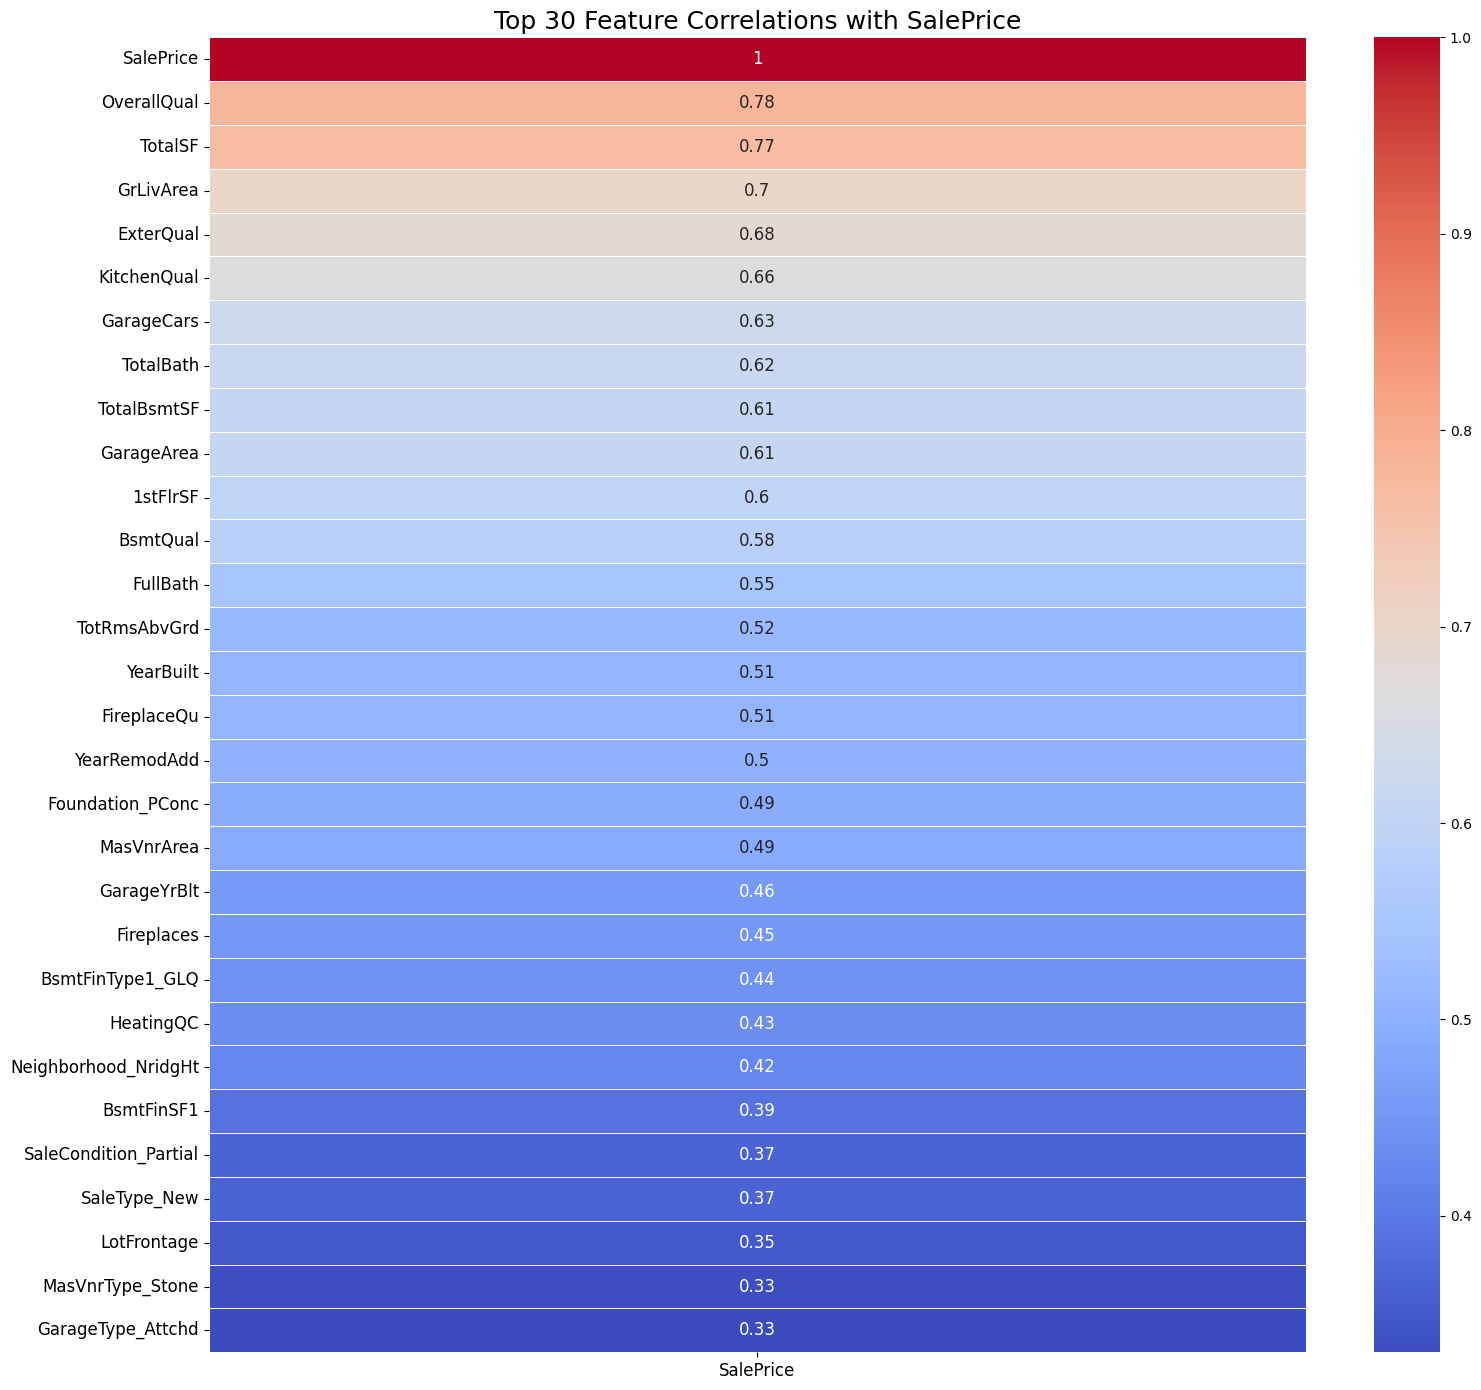

Model Evaluation:
R2 Score:  0.8909
RMSE:      24277.58


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

try:
    df = pd.read_csv("train.csv")
except FileNotFoundError:
    from google.colab import files
    uploaded = files.upload()
    df = pd.read_csv("train.csv")

y = df['SalePrice']
X = df.drop(['Id', 'SalePrice'], axis=1)

cat_na_cols = [
    'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType'
]
X[cat_na_cols] = X[cat_na_cols].fillna("None")

num_na_cols = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
X[num_na_cols] = X[num_na_cols].fillna(X[num_na_cols].median())

missing_rows = X.isnull().any(axis=1)
X = X[~missing_rows]
y = y[~missing_rows]

X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
X['TotalBath'] = X['FullBath'] + 0.5 * X['HalfBath'] + X['BsmtFullBath'] + 0.5 * X['BsmtHalfBath']
X['HouseAge'] = X['YrSold'] - X['YearBuilt']
X['SinceRemod'] = X['YrSold'] - X['YearRemodAdd']
X['TotalPorchSF'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['3SsnPorch'] + X['ScreenPorch']
X['YearMonth'] = X['YrSold'] * 12 + X['MoSold']

quality_map = {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
ordinal_cols = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
    'HeatingQC', 'KitchenQual', 'FireplaceQu',
    'GarageQual', 'GarageCond', 'PoolQC'
]
for col in ordinal_cols:
    if col in X.columns:
        X[col] = X[col].map(quality_map)

categorical_cols = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.to_csv("X_train_processed.csv", index=False)
X_test.to_csv("X_test_processed.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

plt.figure(figsize=(16, 14))
corr = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1).corr()
top_corr = corr[["SalePrice"]].sort_values(by="SalePrice", ascending=False).head(30)
sns.heatmap(top_corr, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 12})
plt.title("Top 30 Feature Correlations with SalePrice", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("feature_correlation.png", dpi=300)
plt.show()

model = Ridge(alpha=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Model Evaluation:")
print(f"R2 Score:  {r2:.4f}")
print(f"RMSE:      {rmse:.2f}")
